In [1]:
import os
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot  as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

from matplotlib import rcParams

rcParams['font.family'] = 'SimHei'
%matplotlib inline

In [2]:
file_dir = "./eth-nft-token-transfers"
all_file_list = os.listdir(file_dir)

In [3]:
all_df = None
for index, single_file in enumerate(all_file_list):
    single_df= pd.read_csv(
        open(os.path.join(file_dir, single_file),'r'),
        # dtype={"amount": str, "transaction_type": str}
    )
    # 去除zero address
    # single_df = single_df.drop(index=single_df[(single_df.to_address == '0x0000000000000000000000000000000000000000')].index.to_list())
    if index == 0:
        all_df = single_df
    else:
        all_df = pd.concat([all_df, single_df], ignore_index=True)

C:\Users\60198\AppData\Local\Temp\ipykernel_11748\1419560737.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  single_df= pd.read_csv(
C:\Users\60198\AppData\Local\Temp\ipykernel_11748\1419560737.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  single_df= pd.read_csv(
C:\Users\60198\AppData\Local\Temp\ipykernel_11748\1419560737.py:3: DtypeWarning: Columns (0,14) have mixed types. Specify dtype option on import or set low_memory=False.
  single_df= pd.read_csv(
C:\Users\60198\AppData\Local\Temp\ipykernel_11748\1419560737.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  single_df= pd.read_csv(
C:\Users\60198\AppData\Local\Temp\ipykernel_11748\1419560737.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  single_df= pd.read_csv(
C:\Users\60198\AppData\Local\Tem

In [4]:
o = all_df.to_address.apply(lambda x: 0 if x =='0x0000000000000000000000000000000000000000' else 1)
print(o.unique())

[1 0]


In [4]:
bh_label_encoder = LabelEncoder() #block—hash
ct_label_encoder = LabelEncoder() #
token_address_label_encoder = LabelEncoder()
th_label_encoder = LabelEncoder()
all_df.block_hash = bh_label_encoder.fit_transform(all_df.block_hash)

all_df.contract_type = ct_label_encoder.fit_transform(all_df.contract_type)

all_df.from_address = all_df.from_address.apply(lambda x: 0 if x =='0x0000000000000000000000000000000000000000' else 1)

all_df.to_address = all_df.to_address.apply(lambda x: 0 if x =='0x0000000000000000000000000000000000000000' else 1)

all_df.token_address = token_address_label_encoder.fit_transform(all_df.token_address)

all_df.transaction_type =all_df.transaction_type.apply(lambda x: 1 if x=='Single' else 0)

all_df.transaction_hash = th_label_encoder.fit_transform(all_df.transaction_hash)

all_df.is_batch = all_df.is_batch.apply(lambda x: 1 if x==True else 0)
all_df.value = all_df.value.apply(lambda x: 0 if int(x) == 0 else 0)
all_df.operator = all_df.operator.apply(lambda x: 0 if x is np.NaN else 1)

In [13]:
#给transaction 分类

df = all_df.fillna(0)
df = df.drop(columns=['block_timestamp', 'log_index', 'transaction_index', 'block_number', 'block_hash','transaction_hash'], axis=1)
# 归一化
# min_scaler = MinMaxScaler()
# df = min_scaler.fit_transform(df)
print(df.shape)
min_scaler = MinMaxScaler()
df = min_scaler.fit_transform(df)
pca = PCA(n_components=0.8)
pca_df = pca.fit_transform(df)
print(pca.n_components_)
print(pca_df.shape)
# print(df[0])
# print(pca_df[0])
print(pca.explained_variance_ratio_)

(13316554, 11)
3
(13316554, 3)
[0.45831993 0.23183086 0.14349615]


In [14]:

# silhouette_score 返回所有样本的轮廓系数的均值
# silhouette_samples 返回每个样本的轮廓系数
# 查看inertia随着n_clusters的变化

inertia_scores = []
meandistortions = []
calin_scores = []
sil_scores = []
davies_scores = []
labels = []
batch_size = 10000
df = pca_df
df = df.astype(np.float32)
for n in range(2, 11) :
    # 使用MiniBatchKMeans 加速训练的速度， 使用k-means++初始化
    km = MiniBatchKMeans(init='k-means++',batch_size=batch_size,n_clusters=n, random_state=28)
    t0 = time.time()
    km.fit(df)
    inertia_scores.append(km.inertia_)
    meandistortions.append(sum(np.min(cdist(df, km.cluster_centers_, "euclidean"), axis=1))/df.shape[0])

    print("n_clusters: {}\tinertia: {}".format(n, km.inertia_))
    t1 = time.time()
    print("train cost time: ", t1 - t0)
    labels.append(km.labels_)

    # 轮廓系数接收的参数中，第二个参数至少有两个分类
    # sc = silhouette_score(df, km.labels_, metric='cosine', sample_size=50000)
    # sil_scores.append(sc)
    # print("n_clusters: {}\tinertia: {}\tsilhoutte_score: {}".format(
    #     n, km.inertia_, sc))

    t2 = time.time()

    print("silhouette cost time: ", t2-t1)
    calinski_score = calinski_harabasz_score(df, km.labels_)
    calin_scores.append(calinski_score)
    davies_score = davies_bouldin_score(df, km.labels_)
    davies_scores.append(davies_score)
    print("calin cost time: ", time.time() - t2)
    print("n_clusters: {}\tcalinski_harabasz_score: {}".format(
        n, calinski_score))
    print("n_clusters: {}\tdavies_score: {}".format(
        n, davies_score))


# 可以看出inertia的值是越来越小的。但是我们观察原始数据
# 显然分为2-5类是最好的结果，所以这里的inertia作为指标不太适用


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 2	inertia: 4060589.25
train cost time:  2.353677988052368
silhouette cost time:  0.0
calin cost time:  2.1489360332489014
n_clusters: 2	calinski_harabasz_score: 10384625.732206998
n_clusters: 2	davies_score: 0.9257180906929768


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 3	inertia: 2267751.0
train cost time:  2.228966474533081
silhouette cost time:  0.0
calin cost time:  2.2855701446533203
n_clusters: 3	calinski_harabasz_score: 14690932.06340688
n_clusters: 3	davies_score: 0.7724414970760168


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 4	inertia: 1328815.125
train cost time:  2.3464348316192627
silhouette cost time:  0.0
calin cost time:  2.4288330078125
n_clusters: 4	calinski_harabasz_score: 19569790.42504424
n_clusters: 4	davies_score: 0.661350681195881


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 5	inertia: 464889.75
train cost time:  2.9543306827545166
silhouette cost time:  0.0
calin cost time:  2.5685513019561768
n_clusters: 5	calinski_harabasz_score: 48120498.901221946
n_clusters: 5	davies_score: 0.4853701378990497


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 6	inertia: 219864.609375
train cost time:  2.506725549697876
silhouette cost time:  0.0
calin cost time:  2.631821632385254
n_clusters: 6	calinski_harabasz_score: 83623126.28544243
n_clusters: 6	davies_score: 0.4763448556799621


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 7	inertia: 81330.5625
train cost time:  2.794828414916992
silhouette cost time:  0.0
calin cost time:  2.8004162311553955
n_clusters: 7	calinski_harabasz_score: 186564927.80229148
n_clusters: 7	davies_score: 0.3919352858552622


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 8	inertia: 17774.1171875
train cost time:  2.6258304119110107
silhouette cost time:  0.0
calin cost time:  2.721242666244507
n_clusters: 8	calinski_harabasz_score: 633536460.7883804
n_clusters: 8	davies_score: 0.08285926690161358


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 9	inertia: 11641.8251953125
train cost time:  2.672180414199829
silhouette cost time:  0.0
calin cost time:  2.8549857139587402
n_clusters: 9	calinski_harabasz_score: 940374013.0016172
n_clusters: 9	davies_score: 0.19256446891763387


D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_clusters: 10	inertia: 9892.0048828125
train cost time:  2.710268020629883
silhouette cost time:  0.0
calin cost time:  3.006296396255493
n_clusters: 10	calinski_harabasz_score: 1037180768.055912
n_clusters: 10	davies_score: 0.28074722749453856


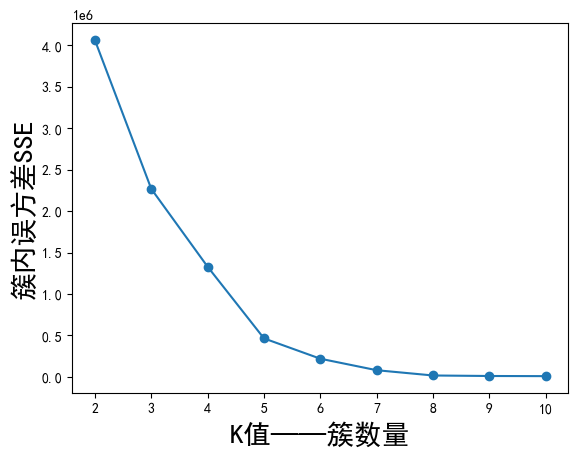

In [15]:
    #绘制曲线
plt.plot(range(2,11),inertia_scores,marker="o")
plt.xlabel("K值——簇数量",size=20)
plt.ylabel("簇内误方差SSE",size=20)
plt.show()


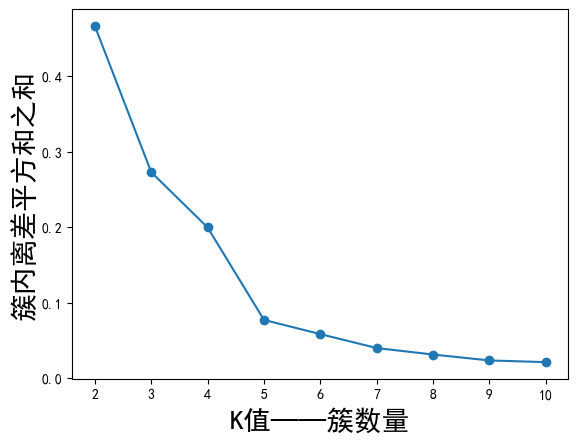

In [16]:
#肘部法
plt.plot(range(2,11),meandistortions,marker="o")
plt.xlabel("K值——簇数量",size=20)
plt.ylabel("簇内离差平方和之和",size=20)
plt.show()

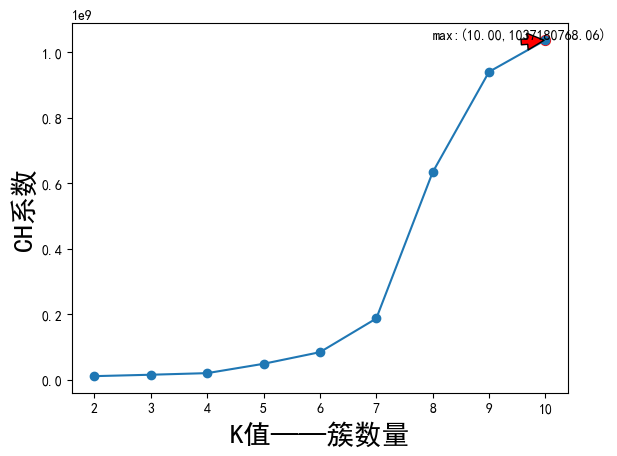

In [17]:
#CH系数
max_idx = np.argmax(calin_scores)
max_x = range(2, 11)[max_idx]
max_y = calin_scores[max_idx]
plt.plot(range(2,11),calin_scores,marker="o")
plt.xlabel("K值——簇数量",size=20)
plt.ylabel("CH系数",size=20)
plt.scatter(max_x, max_y, color='red', s=50)
plt.annotate(f'max:({max_x:.2f},{max_y:.2f})', xy=(max_x, max_y), xytext=(max_x-2, max_y+0.005),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

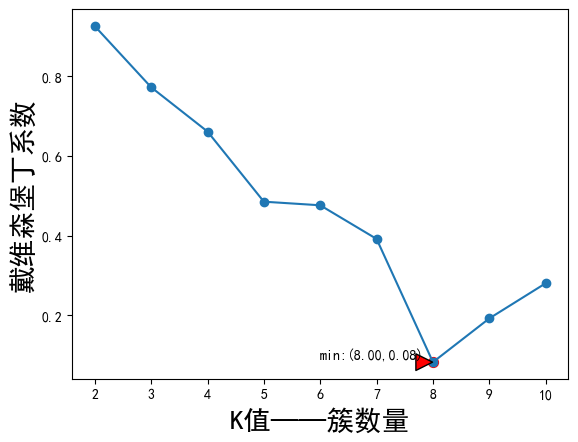

In [18]:
#戴维森堡丁系数
min_idx = np.argmin(davies_scores)
min_x = range(2, 11)[min_idx]
min_y = davies_scores[min_idx]
plt.plot(range(2,11),davies_scores,marker="o")
plt.xlabel("K值——簇数量",size=20)
plt.ylabel("戴维森堡丁系数",size=20)
plt.scatter(min_x, min_y, color='red', s=50)
plt.annotate(f'min:({min_x:.2f},{min_y:.2f})', xy=(min_x, min_y), xytext=(min_x-2, min_y+0.005),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

In [19]:
#综合四个参数
# 所以k选5时候的效果最好
km = MiniBatchKMeans(init='k-means++',batch_size=batch_size,n_clusters=8, random_state=28)
y_pred = km.fit_predict(df)

D:\softs\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


D:\softs\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


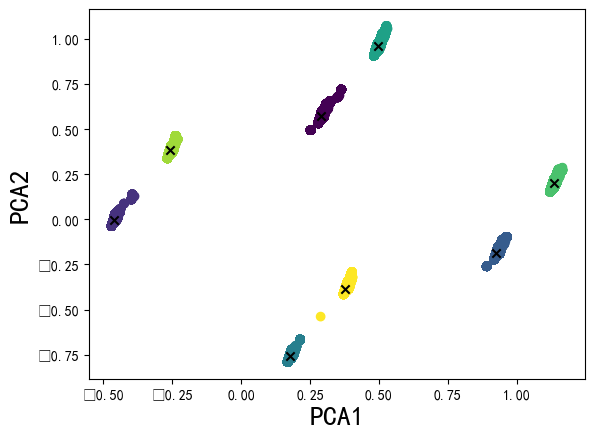

In [20]:
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=km.labels_)
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black', marker='x')
plt.xlabel("PCA1",size=20)
plt.ylabel("PCA2",size=20)
plt.show()

In [5]:
# if choose to classify transaction type
# so y is 'transaction_type'
# 太卡了
# y = all_df.transaction_type
# X = all_df.fillna(0)
# X = X.drop(columns=['block_timestamp', 'log_index', 'transaction_index', 'block_number', 'block_hash','transaction_hash', 'transaction_type'], axis=1)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)




In [7]:
# # 定义参数列表
# param_grid = parameters = [
#     {'C': [1, 10, 100], 'kernel': ['linear']},
#     {'C': [1, 10, 100], 'kernel': ['rbf'], 'gamma': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
# ]
#
# # 定义GridSearchCV对象，注意参数
# # 参数1-模型
# # 参数2-参数列表
# # 参数3-交叉验证次数（网格搜索具有交叉验证功能）
# grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring="accuracy", n_jobs=5)
#
# grid_search.fit(X_train, y_train) # 将训练数据交给GridSearchCV对象
#
# # 输出最佳参数组合及最佳成绩（利用.best_params_和.best_score_属性）
# print("Best parameters: {}".format(grid_search.best_params_))
# print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.